First of all, set autoreload on for hot reload of imported files 

In [1]:
%load_ext autoreload
%autoreload 2

# Import Libraries

In [7]:
from src.data_processing import DataProcessor
from src.model_training import ModelTrainer
from src.evaluation import Evaluator
from src.visualization import Visualizer
from src.utils import timer

import pandas as pd
import os
from datetime import datetime

# Define pipeline configurations

In [ ]:
vectorizers = ['tfidf', 
            'count'
            ]
models = [
    'logistic_regression',
    'decision_tree', # too slow
    'random_forest', # too slow
    'mlp', # too slow
    'knn'
]


# Run Models

In [4]:
results = []

for vectorizer_type in vectorizers:
    for model_type in models:
        print(f"Testing combination: Vectorizer={vectorizer_type}, Model={model_type}")
        
        # Initialize Data Processor
        data_processor = DataProcessor(vectorizer_type=vectorizer_type)
        
        # Load and split data
        data = data_processor.load_data('data/extracted_data.csv')
        X_train_text, X_test_text, y_train, y_test = data_processor.split_data(data)
        
        # Fit and transform training data
        with timer("Vectorization and Quantization"):
            X_train_quantized = data_processor.fit_transform(X_train_text)
            X_test_quantized = data_processor.transform(X_test_text)
        
        # Initialize Model Trainer
        model_trainer = ModelTrainer(model_type=model_type)
        
        # Train the model
        with timer("Model Training"):
            model_trainer.train(X_train_quantized, y_train)
        
        # Compile the model
        representative_data = X_train_quantized[:100]
        with timer("Model Compilation"):
            model_trainer.compile(representative_data, model_name=f'{vectorizer_type}_{model_type}')
        
        # Load FHE Model
        model_trainer.load_fhe_model()
        # Evaluate the model on plaintext
        evaluator = Evaluator()
        y_pred_plaintext, prediction_time = evaluator.measure_prediction_time(model_trainer.model, X_test_quantized)
        metrics_plaintext = evaluator.evaluate(y_test, y_pred_plaintext)
        # Perform encrypted inference on a larger subset
        with timer("Encrypted Inference"):
            y_pred_encrypted, y_test_subset = evaluator.measure_fhe_prediction_performance(
                model_trainer, X_test_text, y_test, data_processor, sample_ratio=0.01 # thats %1 of the TEST data. 
                                                                                      # So it is %0.2 of the whole data we are testing on
                                                                                      # And it still takes a lot of time
            )

        # Record results
        result = {
            'Vectorizer': vectorizer_type,
            'Model': model_type,
            'Training Time': model_trainer.training_time,
            'Compilation Time': model_trainer.compilation_time,
            'Plaintext Prediction Time': prediction_time,
            'FHE Encryption Time': evaluator.metrics['fhe_encryption_time'],
            'FHE Inference Time': evaluator.metrics['fhe_inference_time'],
            'FHE Decryption Time': evaluator.metrics['fhe_decryption_time'],
            'Accuracy': metrics_plaintext['accuracy'],
            'Recall': metrics_plaintext['recall'],
            'Precision': metrics_plaintext['precision'],
            'F1 Score': metrics_plaintext['f1_score'],
            'ROC AUC': metrics_plaintext['roc_auc'],
            # Add other metrics as needed
        }
        results.append(result)
        print("="*100)

Testing combination: Vectorizer=tfidf, Model=logistic_regression
[Vectorization and Quantization] Elapsed time: 7.82 seconds
[Model Training] Elapsed time: 9.33 seconds
[Model Compilation] Elapsed time: 0.56 seconds


Inference Progress:   0%|          | 0/30 [00:00<?, ?it/s]

[Encrypted Inference] Elapsed time: 15.06 seconds
Testing combination: Vectorizer=count, Model=logistic_regression
[Vectorization and Quantization] Elapsed time: 4.92 seconds
[Model Training] Elapsed time: 8.08 seconds
[Model Compilation] Elapsed time: 0.30 seconds


Inference Progress:   0%|          | 0/30 [00:00<?, ?it/s]

[Encrypted Inference] Elapsed time: 16.99 seconds


# Create reports

In [8]:
# Ensure the results directory exists
os.makedirs('results', exist_ok=True)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Add a combination column for better visualization
results_df['Combination'] = results_df['Vectorizer'] + ' + ' + results_df['Model']

# Print the DataFrame for verification
print(results_df)

# Save results to a CSV file with timestamp

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_csv_path = f'results/experiment_results_{timestamp}.csv'
results_df.to_csv(results_csv_path, index=False)

print(f"Results saved to {results_csv_path}")


  Vectorizer                Model  Training Time  Compilation Time  \
0      tfidf  logistic_regression       9.327428          0.410058   
1      count  logistic_regression       8.079755          0.175145   

   Plaintext Prediction Time  FHE Encryption Time  FHE Inference Time  \
0                   0.081010             0.397748            0.760780   
1                   0.083262             0.425472            0.990942   

   FHE Decryption Time  Accuracy    Recall  Precision  F1 Score   ROC AUC  \
0             0.001106  0.978333  0.976043   0.973786  0.974913  0.978057   
1             0.001988  0.965000  0.958269   0.960496  0.959381  0.964187   

                   Combination  
0  tfidf + logistic_regression  
1  count + logistic_regression  
Results saved to results/experiment_results_20241117_145843.csv


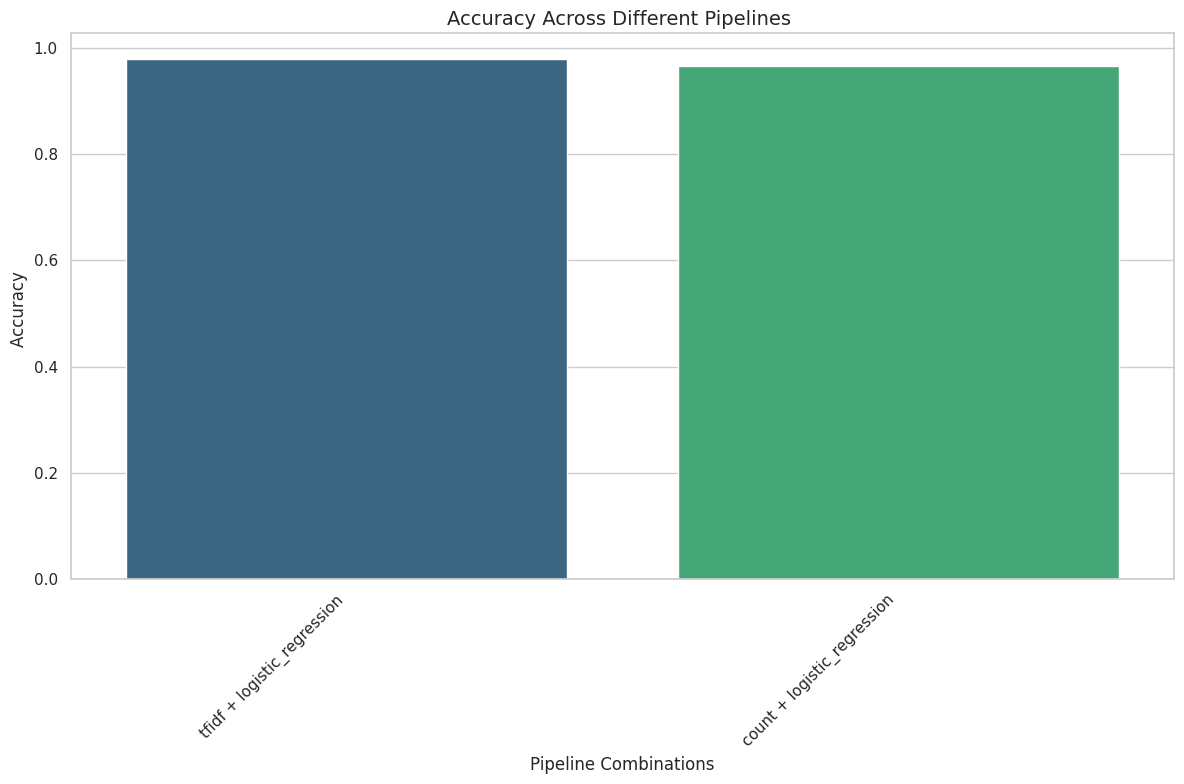

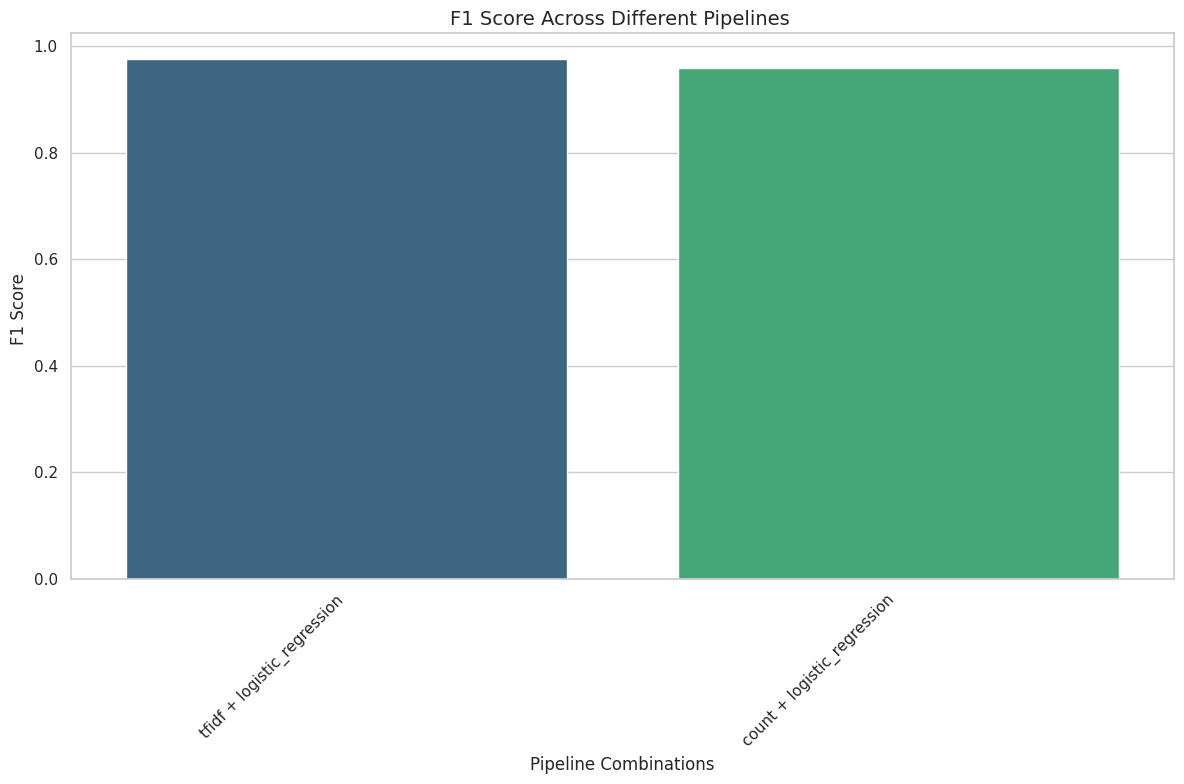

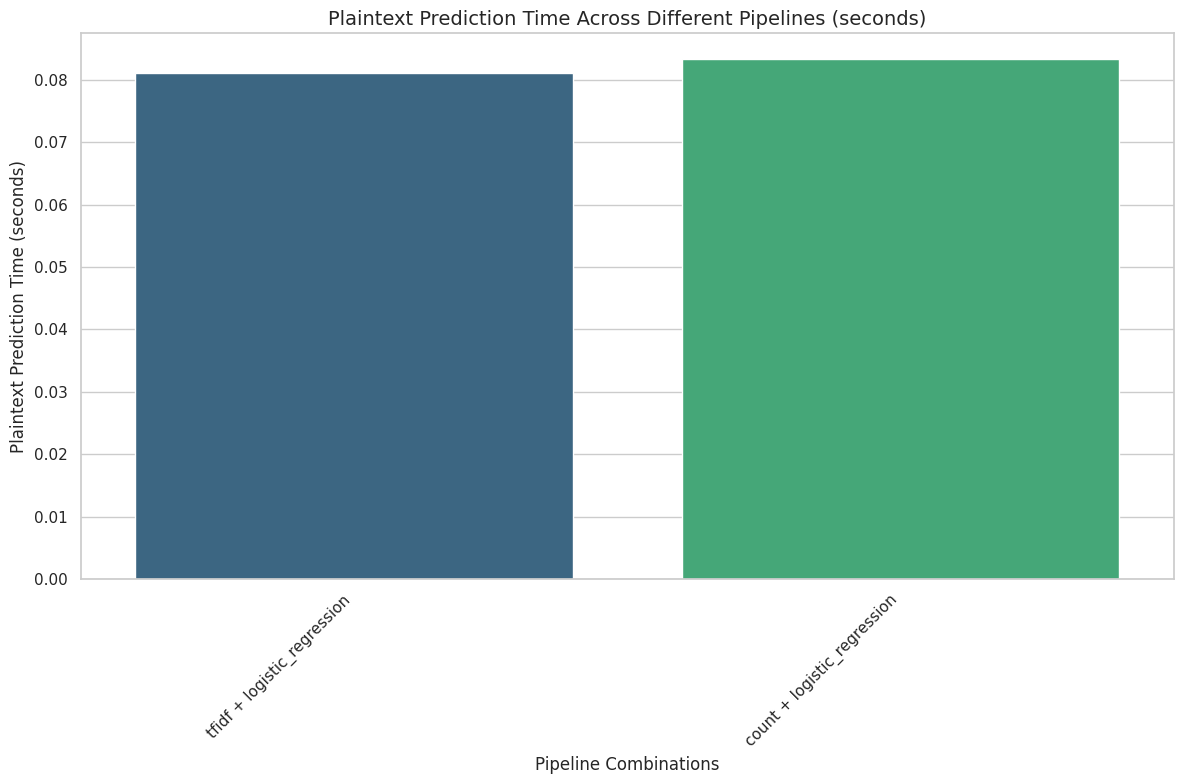

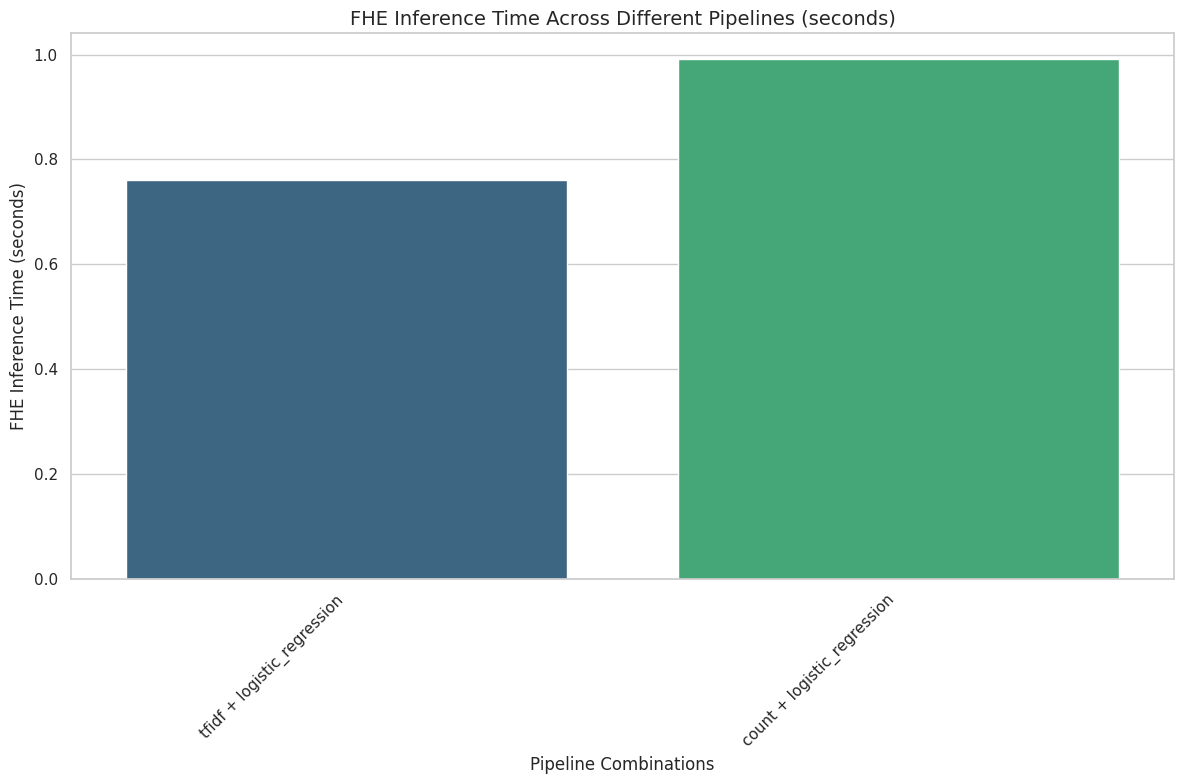

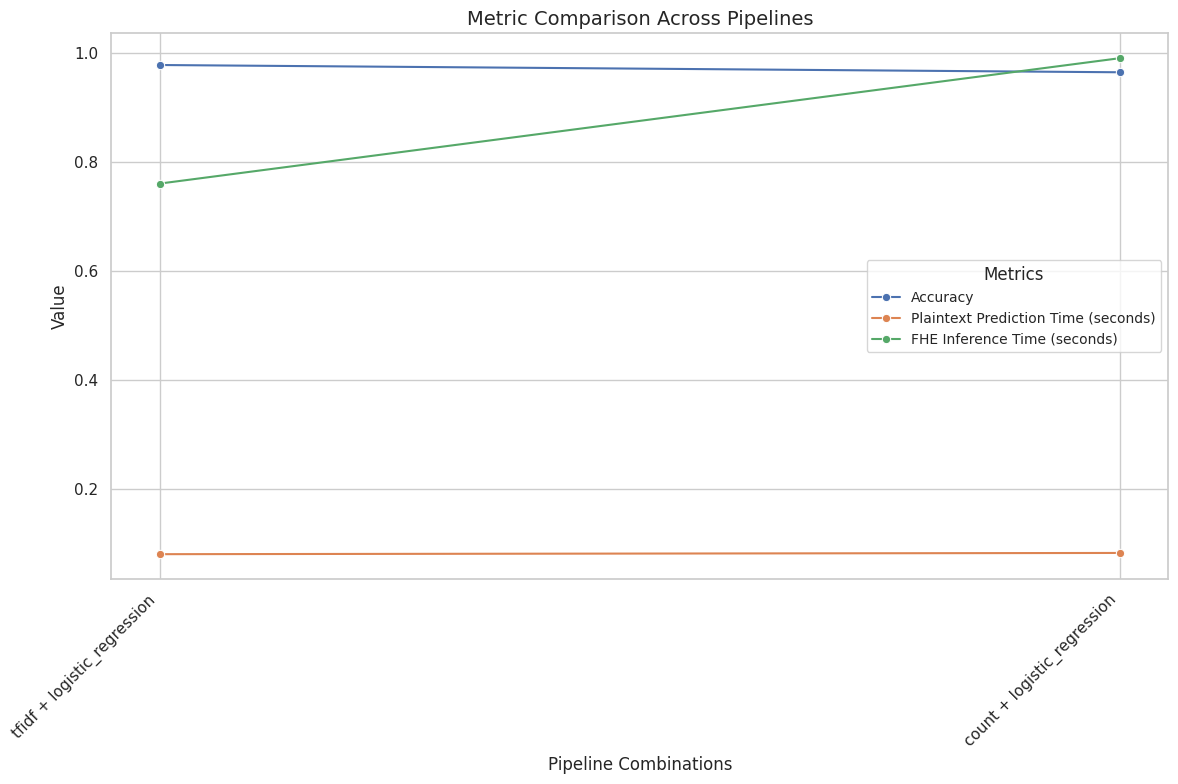

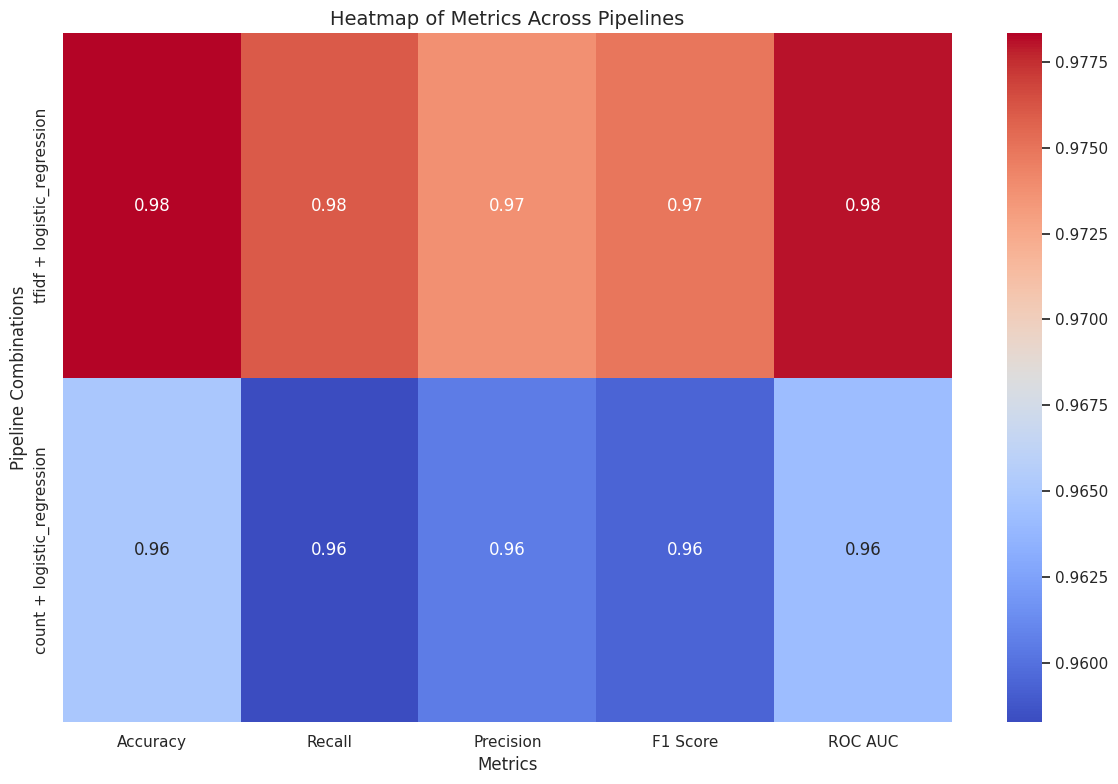

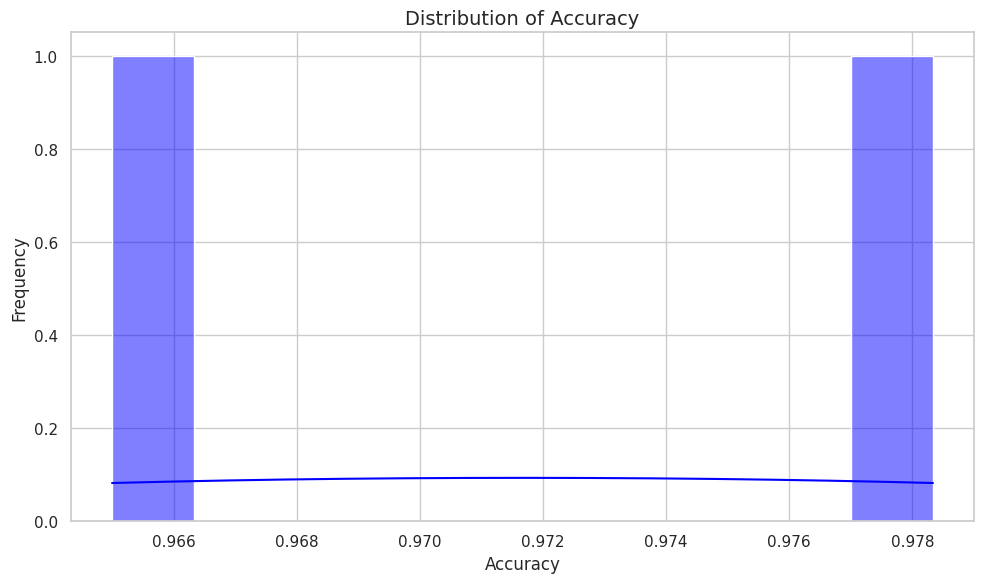

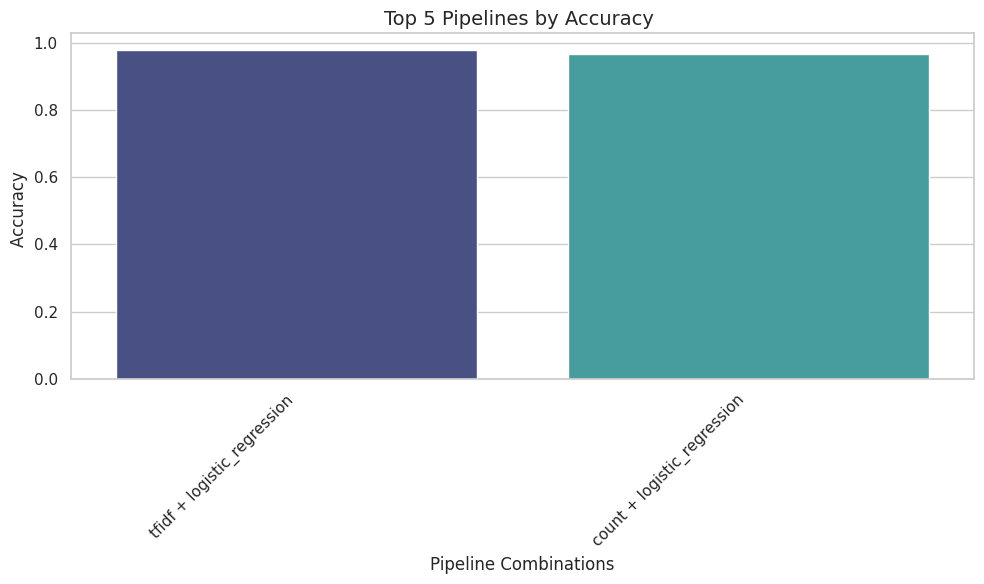

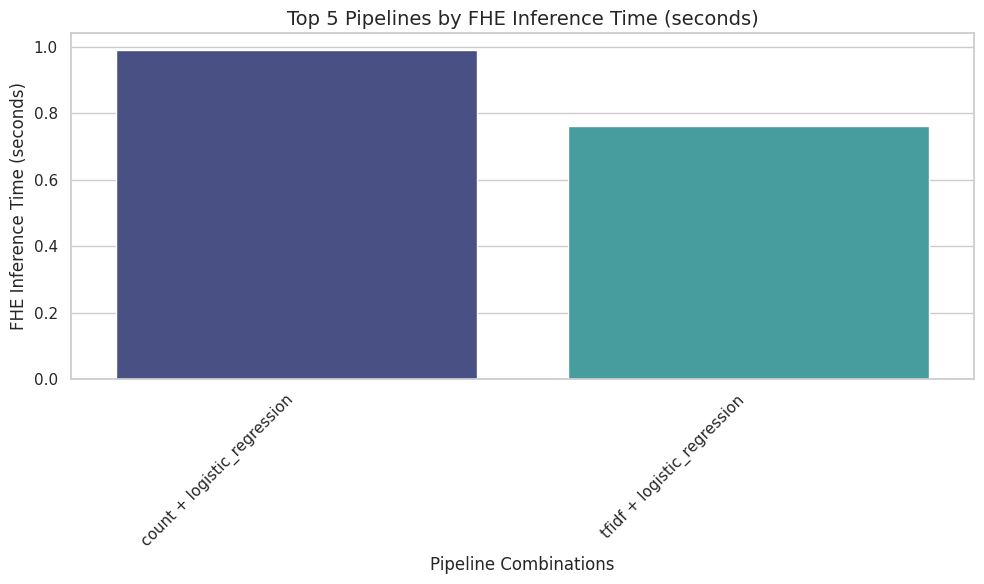

In [6]:
# Visualize the Results
visualizer = Visualizer()

# Plot individual metrics
visualizer.plot_bar(results_df, 'Accuracy')
visualizer.plot_bar(results_df, 'F1 Score')
visualizer.plot_bar(results_df, 'Plaintext Prediction Time', unit='seconds')
visualizer.plot_bar(results_df, 'FHE Inference Time', unit='seconds')

# Comparison plot with time unit
visualizer.plot_comparison(
    results_df, 
    ['Accuracy', 'Plaintext Prediction Time', 'FHE Inference Time'], 
    time_metrics=['Plaintext Prediction Time', 'FHE Inference Time'], 
    unit='seconds'
)
# Heatmap of metrics for each pipeline
visualizer.plot_heatmap(results_df, ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'ROC AUC'])

# Distribution of a specific metric
visualizer.plot_metric_distribution(results_df, 'Accuracy')

# Top 5 pipelines by a specific metric
visualizer.plot_top_n(results_df, 'Accuracy', n=5)
visualizer.plot_top_n(results_df, 'FHE Inference Time', n=5, unit='seconds')